In [889]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
import h5py
from collections import defaultdict

from timeit import default_timer as timer

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder 

import torch
import torchvision.transforms as transforms
from skimage.util import random_noise

from keras.preprocessing.image import load_img, img_to_array
from keras.utils import to_categorical
from keras.models import Model
from keras.models import Sequential
from tensorflow.keras import layers, models
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, concatenate, Dropout, Reshape
from keras.optimizers import Adam
from keras.losses import mean_squared_error, categorical_crossentropy, binary_crossentropy
from keras.callbacks import EarlyStopping
from keras.metrics import MeanIoU, IoU
import keras.backend as K

import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Conv2DTranspose
from tensorflow.keras.metrics import Recall, Precision, MeanAbsoluteError, F1Score
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import BinaryFocalCrossentropy, CategoricalFocalCrossentropy


In [890]:
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
working_path = os.path.join(parent_dir) #incase directory needs to be expanded
downloads_path = os.path.expanduser("~\\Downloads")
extract_dir = os.path.expanduser("~\\Data_science")

In [891]:
# Set up folder paths
# Define the source paths for images and annotations
image_pool_path = os.path.join(extract_dir, 'VOC_PCB', 'JPEGImages')
annot_pool_path = os.path.join(extract_dir, 'VOC_PCB', 'Annotations')

# Define the destination path for images and annotations
image_dest_path = os.path.join(working_path, 'data', 'Images')
annot_dest_path = os.path.join(working_path, 'data', 'Annotations')

# Define the destination path for bboxes and masks
bb_path = os.path.join(working_path, 'data', 'Images_bb')
mask_path = os.path.join(working_path, 'data', 'Pixel_masks')

# Define the destination path for csv file
csv_path = os.path.join(working_path, 'data', 'csv')

In [892]:
image_dataset_path = image_dest_path

In [893]:
# train and test dataset file paths
train_path =  os.path.join(downloads_path, "train_data.h5")
test_path =  os.path.join(downloads_path, "test_data.h5")

Loading Training and Testing datasets

In [894]:
# load train dataset
with h5py.File(train_path, 'r') as hf:
    X_train = hf['X'][:]
    y_train_mask = hf['y_mask'][:]
    y_train_class = hf['y_class'][:]

print(f"X_train shape: {X_train.shape}")
print(f"y_train_mask shape: {y_train_mask.shape}")
print(f"y_train_class shape: {y_train_class.shape}")

X_train shape: (11900, 100, 100)
y_train_mask shape: (11900, 100, 100)
y_train_class shape: (11900, 7)


In [895]:
# load test dataset
with h5py.File(test_path, 'r') as hf:
    X_test = hf['X'][:]
    y_test_mask = hf['y_mask'][:]
    y_test_class = hf['y_class'][:]

print(f"X_test shape: {X_test.shape}")
print(f"y_test_mask shape: {y_test_mask.shape}")
print(f"y_test_class shape: {y_test_class.shape}")

X_test shape: (392, 100, 100)
y_test_mask shape: (392, 100, 100)
y_test_class shape: (392, 7)


Initializing functions for deep learning model

In [915]:
################################
#           Focal loss         #
################################
@tf.function
def focal_loss(gamma=2., alpha=.25):
	def focal_loss_fixed(y_true, y_pred):
		pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
		pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
		return -tf.reduce_mean(alpha * tf.math.pow(1. - pt_1, gamma) * tf.math.log(pt_1+K.epsilon())) - tf.reduce_mean((1 - alpha) * tf.math.pow(pt_0, gamma) * tf.math.log(1. - pt_0 + K.epsilon()))
	return focal_loss_fixed


In [916]:
# Register the function 
tf.keras.utils.get_custom_objects()['focal_loss_fixed'] = focal_loss_fixed

In [897]:
################################
#             Dice             #
################################
# Define the dice function

def DiceLoss(y_true, y_pred, smooth=1e-6):
    
    # if you are using this loss for multi-class segmentation then uncomment 
    # following lines
    # if y_pred.shape[-1] <= 1:
    #     # activate logits
    #     y_pred = tf.keras.activations.sigmoid(y_pred)
    # elif y_pred.shape[-1] >= 2:
    #     # activate logits
    #     y_pred = tf.keras.activations.softmax(y_pred, axis=-1)
    #     # convert the tensor to one-hot for multi-class segmentation
    #     y_true = K.squeeze(y_true, 3)
    #     y_true = tf.cast(y_true, "int32")
    #     y_true = tf.one_hot(y_true, num_class, axis=-1)
    
    # cast to float32 datatype
    y_true = tf.cast(y_true, 'float32')
    y_pred = tf.cast(y_pred, 'float32')
    
    # Flatten label and prediction tensors
    y_true = tf.keras.backend.flatten(y_true)
    y_pred = tf.keras.backend.flatten(y_pred)
    
    intersection = tf.reduce_sum(y_true * y_pred)
    dice = (2 * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)
    return 1 - dice

In [917]:
# Register the function 
tf.keras.utils.get_custom_objects()['DiceLoss'] = DiceLoss

In [898]:
class TimingCallback(Callback):
    def __init__(self, max_duration_seconds, logs={}):
        self.logs=[]
        self.max_duration_seconds = max_duration_seconds
            
    def on_train_begin(self, logs={}):
        self.start_time = timer()
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)
        total_duration = timer() - self.start_time
        if total_duration > self.max_duration_seconds:
            print(f"Stopping training after {total_duration / 3600} hours")
            self.model.stop_training = True


In [899]:
early_stopping = EarlyStopping(
                                patience=10, 
                                min_delta = 0.0001, 
                                verbose=1,
                                mode = 'min',
                                monitor='val_loss')

reduce_learning_rate = ReduceLROnPlateau(
                                        monitor="val_loss",
                                        patience=5, 
                                        min_delta= 0.0001,
                                        factor=0.1,  
                                        cooldown = 6, 
                                        verbose=1)

checkpoint = ModelCheckpoint(
                            'best_model_params_res_unet.keras', 
                            monitor='val_loss', 
                            verbose=1, 
                            #save_best_only=True, 
                            mode='min')


time_callback = TimingCallback(36000) # 36000 = 10 hrs, 18000 = 5 hrs, 7200 = 2 hrs

In [900]:
def elegant_res_unet_segmentation_classification(input_shape, num_classes): #Res-unet combo
   
    inputs = layers.Input(shape=input_shape)

    # RES part of model: residual skip connections
    def conv_block(input_tensor, num_filters):
        x = layers.Conv2D(num_filters, 3, activation='relu', padding='same')(input_tensor)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(num_filters, 3, activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        
        input_tensor_transformed = layers.Conv2D(num_filters, 1, activation=None, padding='same')(input_tensor)
        input_tensor_transformed = layers.BatchNormalization()(input_tensor_transformed)
        
        return layers.add([x, input_tensor_transformed])

    # Encoder contraction layers with residual skip connections
    conv1 = conv_block(inputs, 64)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_block(pool1, 128)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    conv3 = layers.DepthwiseConv2D(3, activation='relu', padding='same')(pool2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Conv2D(256, 1, activation='relu', padding='same')(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Conv2D(256, 3, activation='relu', dilation_rate=2, padding='same')(conv3)
    conv3 = layers.BatchNormalization()(conv3)

    # Decoder expansion layers with residual skip connections
    up1 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv3)
    up1 = layers.concatenate([up1, conv2], axis=3)
    conv4 = conv_block(up1, 128)

    up2 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv4)
    up2 = layers.concatenate([up2, conv1], axis=3)
    conv5 = conv_block(up2, 64)

    # Segmentation Output
    segmentation_output = layers.Conv2D(1, 1, activation='sigmoid', name='segmentation_output')(conv5)

    # Classification Head

    flatten = layers.GlobalAveragePooling2D()(conv3)
    dense1 = layers.Dense(256, activation='relu')(flatten)
    dropout1 = layers.Dropout(0.5)(dense1)
    dense2 = layers.Dense(128, activation='relu')(dropout1)
    dropout2 = layers.Dropout(0.5)(dense2)
    classification_output = layers.Dense(num_classes, activation='softmax', name='classification_output')(dropout2)

    # Create Model
    model = models.Model(inputs=inputs, 
                         outputs=[segmentation_output, 
                                  classification_output
                                  ])
    return model

In [901]:
# extracting numer of classes information from dataset 
num_classes = y_train_class.shape[1]
print(num_classes)

7


In [902]:
# extracting input_shape information from dataset 
input_shape = np.expand_dims(X_train, axis=-1)
input_shape = input_shape.shape[1:]
print(input_shape)

(100, 100, 1)


In [903]:
# Instantiate the model
model = elegant_res_unet_segmentation_classification(input_shape=input_shape, num_classes=num_classes)

In [967]:
# Compile the model

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer='adam', #(learning_rate=0.0001)#optimizer,
    loss={
        'segmentation_output': 'binary_crossentropy', #focal_loss(alpha=.25, gamma=2),  # for the mask output with sigmoid 'binary_crossentropy', #
        'classification_output': 'categorical_crossentropy' #"categorical_focal_crossentropy"  # for the classification output with softmax
    },
    loss_weights={
        'segmentation_output': 0.0,  # initially Weighted at 80%, 20%, 100%
        'classification_output': 1.0  # initially Weighted at 20%, 80%. 0%
    },
    metrics={
        'segmentation_output': ['accuracy', MeanAbsoluteError(), MeanIoU(num_classes=num_classes)],  # Metrics for segmentation IoU(num_classes=num_classes, target_class_ids=[0,1,2,3,4,5,6])
        'classification_output': ['accuracy', Recall(), Precision()]  # Metrics for classification
    }
)

In [905]:
model.summary()

Model: "functional_67"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_33      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_462 (Conv2D) │ (None, 100, 100,  │        640 │ input_layer_33[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 100,  │        256 │ conv2d_462[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_463 (Conv2D) │ (None, 100, 100,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_464 (Conv2D) │ (None, 100, 100,  │        128 │ input_layer_33[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 100,  │        256 │ conv2d_463[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 100,  │        256 │ conv2d_464[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_132 (Add)       │ (None, 100, 100,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_66    │ (None, 50, 50,    │          0 │ add_132[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_465 (Conv2D) │ (None, 50, 50,    │     73,856 │ max_pooling2d_66… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 50,    │        512 │ conv2d_465[0][0]  │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_466 (Conv2D) │ (None, 50, 50,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_467 (Conv2D) │ (None, 50, 50,    │      8,320 │ max_pooling2d_66… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 50,    │        512 │ conv2d_466[0][0]  │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 50,    │        512 │ conv2d_467[0][0]  │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_133 (Add)       │ (None, 50, 50,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_67    │ (None, 25, 25,    │          0 │ add_133[0][0]   

 Total params: 1,757,192 (6.70 MB)

 Trainable params: 1,753,608 (6.69 MB)

 Non-trainable params: 3,584 (14.00 KB)

In [906]:
plot_model(model, to_file='elegant_res_unet_segmentation_classification.png', show_shapes=True, show_layer_names=True)

In [907]:
print("X_train shape:", X_train.shape)
print("y_train_mask shape:", y_train_mask.shape)
print("y_train_class shape:", y_train_class.shape)
print("X_test shape:", X_test.shape)
print("y_test_mask shape:", y_test_mask.shape)
print("y_test_class shape:", y_test_class.shape)

print("Expected input shape for the model:", model.input_shape)
print("Model output shape:", model.output_shape)

print("Data type of y_train_class:", y_train_class.dtype)

X_train shape: (11900, 100, 100)
y_train_mask shape: (11900, 100, 100)
y_train_class shape: (11900, 7)
X_test shape: (392, 100, 100)
y_test_mask shape: (392, 100, 100)
y_test_class shape: (392, 7)
Expected input shape for the model: (None, 100, 100, 1)
Model output shape: [(None, 100, 100, 1), (None, 7)]
Data type of y_train_class: float64


In [932]:
total_epochs = 6

In [936]:
# Train the model
history = model.fit(x=X_train, 
                    y=[y_train_mask, y_train_class],
                    epochs=total_epochs,
                    batch_size=32,
                    validation_data=(X_test, [y_test_mask, y_test_class]),
                    callbacks=[ reduce_learning_rate, 
                                #early_stopping, 
                                checkpoint
                                #time_callback
                                ],
                    verbose=True)

Epoch 1/6
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - classification_output_accuracy: 0.8730 - classification_output_precision_37: 0.9731 - classification_output_recall_37: 0.8527 - loss: 0.0636 - segmentation_output_accuracy: 0.9803 - segmentation_output_mean_absolute_error: 0.0398 - segmentation_output_mean_io_u_37: 0.4748
Epoch 1: saving model to best_model_params_res_unet.keras
372/372 ━━━━━━━━━━━━━━━━━━━━ 1434s 4s/step - classification_output_accuracy: 0.8730 - classification_output_precision_37: 0.9731 - classification_output_recall_37: 0.8527 - loss: 0.0636 - segmentation_output_accuracy: 0.9803 - segmentation_output_mean_absolute_error: 0.0398 - segmentation_output_mean_io_u_37: 0.4748 - val_classification_output_accuracy: 0.7628 - val_classification_output_precision_37: 0.7842 - val_classification_output_recall_37: 0.7602 - val_loss: 0.1118 - val_segmentation_output_accuracy: 0.9691 - val_segmentation_output_mean_absolute_error: 0.0372 - val_segmentation_output_mean_io_u_37: 0.4

In [937]:
history_df = pd.DataFrame(history.history)
history_df.to_csv('model_enhanced_res_unet_2.csv', index=False)
model.save('model_enhanced_res_unet_2.keras')

In [941]:
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

train_acc_seg = history.history["segmentation_output_accuracy"]
val_acc_seg = history.history["val_segmentation_output_accuracy"]

train_acc_class = history.history["classification_output_accuracy"]
val_acc_class = history.history["val_classification_output_accuracy"]

train_precision_class = history.history["classification_output_precision_37"]
val_precision_class = history.history["val_classification_output_precision_37"]

train_recall_class = history.history["classification_output_recall_37"]
val_recall_class = history.history["val_classification_output_recall_37"]

train_mae = history.history["segmentation_output_mean_absolute_error"]
val_mae = history.history["val_segmentation_output_mean_absolute_error"]

train_mean_iou = history.history["segmentation_output_mean_io_u_37"]
val_mean_iou = history.history["val_segmentation_output_mean_io_u_37"]


#segmentation_output_weights = history.history['segmentation_output_weight']
#classification_output_weights = history.history['classification_output_weight']


In [942]:
train_classification_f1_score =[]
val_classification_f1_score = []
for i in range(len(train_precision_class)):
    x1 = 2 * (train_precision_class[i] * train_recall_class[i]) / (train_precision_class[i] + train_recall_class[i] + 0.000001)
    x2 = 2 * (val_precision_class[i] * val_recall_class[i]) / (val_precision_class[i] + val_recall_class[i] + 0.000001)
    train_classification_f1_score.append(x1)
    val_classification_f1_score.append(x2)

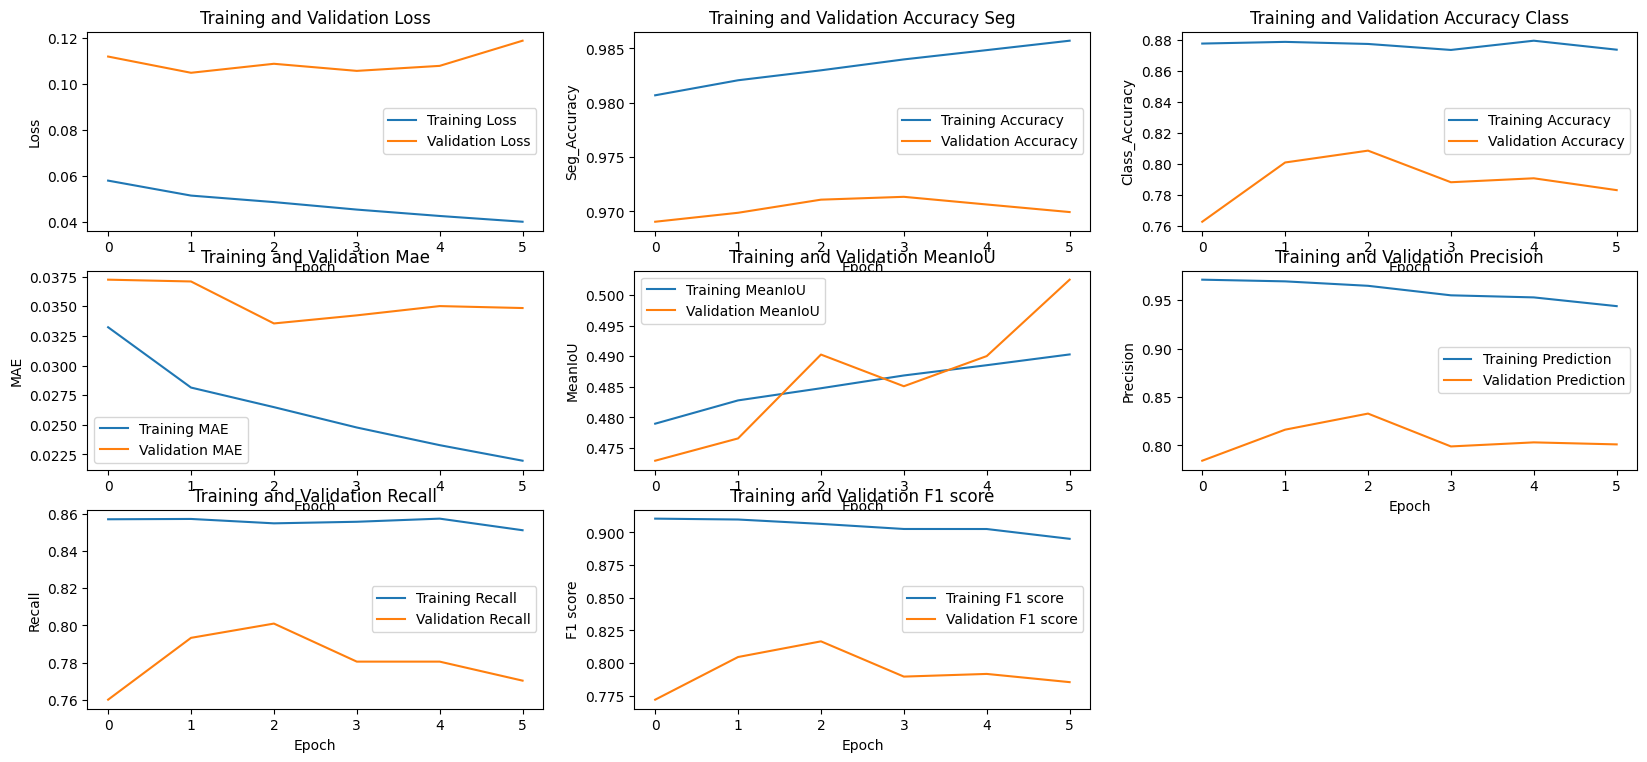

In [943]:
plt.figure(figsize = (20, 15))

plt.subplot(531)
plt.plot(train_loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.subplot(532)
plt.plot(train_acc_seg, label="Training Accuracy")
plt.plot(val_acc_seg, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Seg_Accuracy")
plt.title("Training and Validation Accuracy Seg")
plt.legend()

plt.subplot(533)
plt.plot(train_acc_class, label="Training Accuracy")
plt.plot(val_acc_class, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Class_Accuracy")
plt.title("Training and Validation Accuracy Class")
plt.legend()

plt.subplot(534)
plt.plot(train_mae, label="Training MAE")
plt.plot(val_mae, label="Validation MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title("Training and Validation Mae")
plt.legend()

plt.subplot(535)
plt.plot(train_mean_iou, label="Training MeanIoU")
plt.plot(val_mean_iou, label="Validation MeanIoU")
plt.xlabel("Epoch")
plt.ylabel("MeanIoU")
plt.title("Training and Validation MeanIoU")
plt.legend()

plt.subplot(536)
plt.plot(train_precision_class, label="Training Prediction")
plt.plot(val_precision_class, label="Validation Prediction")
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.title("Training and Validation Precision")
plt.legend()

plt.subplot(537)
plt.plot(train_recall_class, label="Training Recall")
plt.plot(val_recall_class, label="Validation Recall")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.title("Training and Validation Recall")
plt.legend()

plt.subplot(538)
plt.plot(train_classification_f1_score, label="Training F1 score")
plt.plot(val_classification_f1_score, label="Validation F1 score")
plt.xlabel("Epoch")
plt.ylabel("F1 score")
plt.title("Training and Validation F1 score")
plt.legend()


plt.show()



In [944]:
y_mask_pred, y_class_pred = model.predict(X_test)


13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 592ms/step


In [945]:
predicted_labels = np.argmax(y_class_pred, axis=1)

test_labels = np.argmax(y_test_class, axis=1)


class_labels_pred = {
    0: 'missing_hole',
    1: 'mouse_bite',
    2: 'none',
    3: 'open_circuit',
    4: 'short',
    5: 'spur',
    6: 'spurious_copper'
}

remapped_labels = [class_labels_pred[label] for label in predicted_labels]

remapped_test_labels = [class_labels_pred[label] for label in test_labels]


In [946]:
print(len(y_class_pred))

392


In [947]:
output_probabilities = np.array(y_class_pred[0])
confidence = np.max(output_probabilities)
predicted_class = np.argmax(output_probabilities)
print(confidence)
print(f"Predicted Class: {predicted_class}")
print(f"Confidence: {confidence}")

0.9817747
Predicted Class: 1
Confidence: 0.9817746877670288


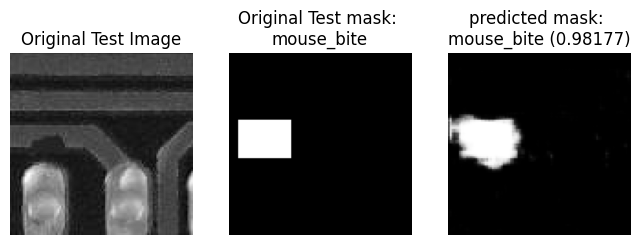

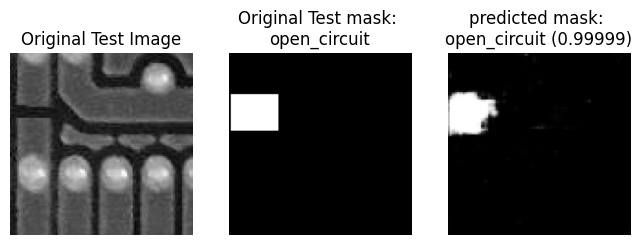

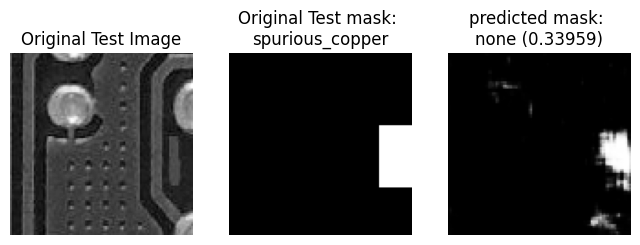

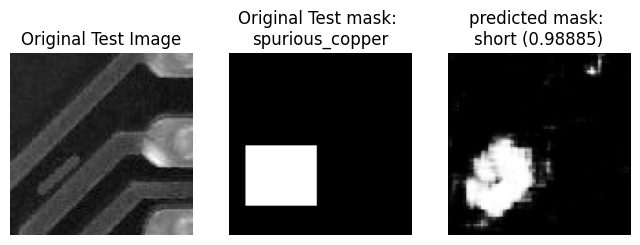

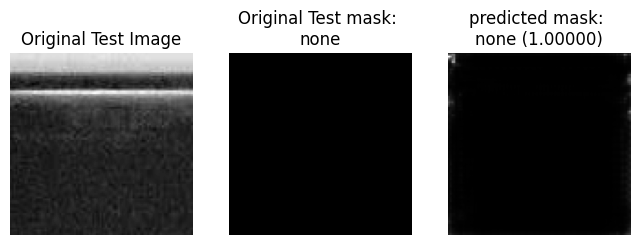

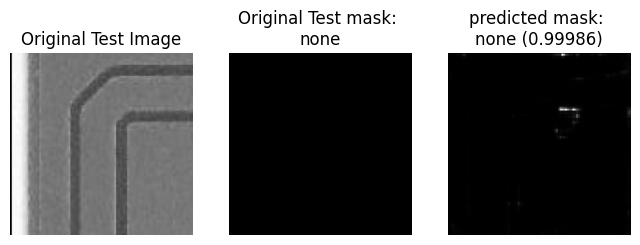

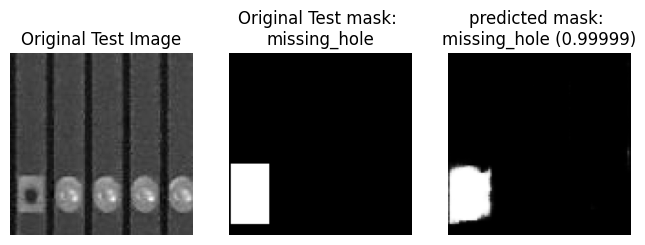

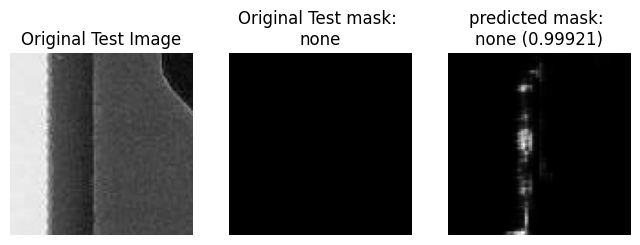

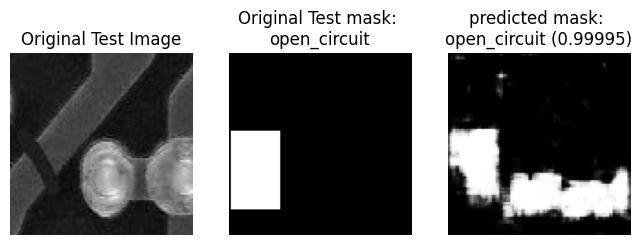

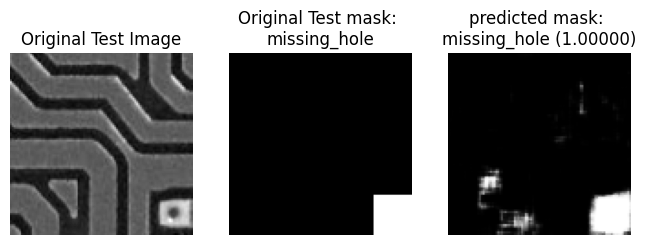

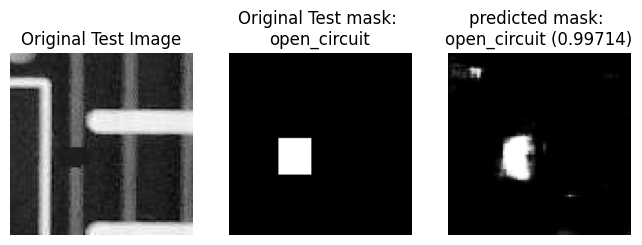

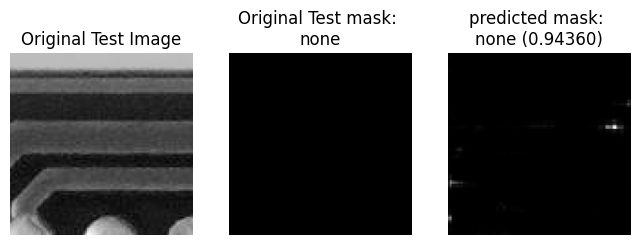

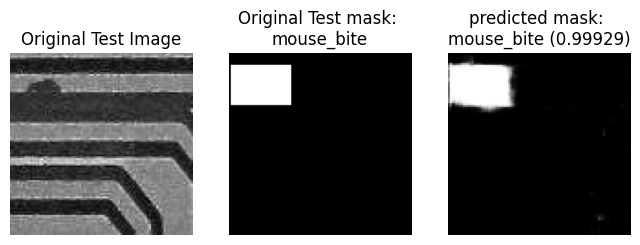

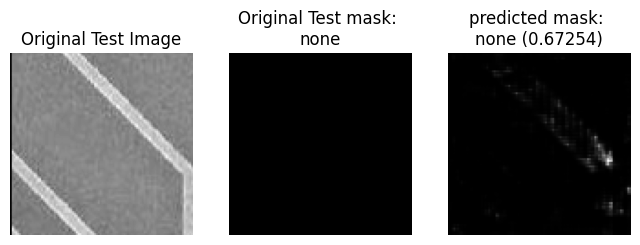

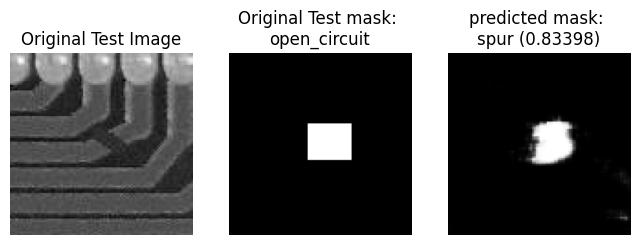

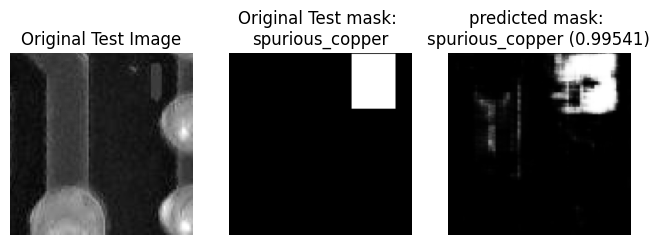

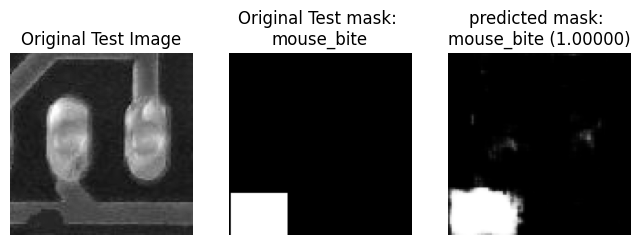

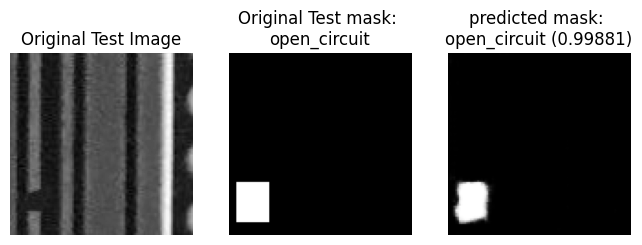

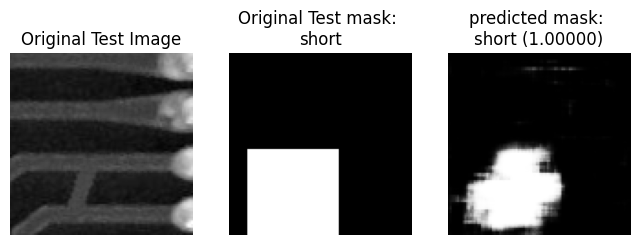

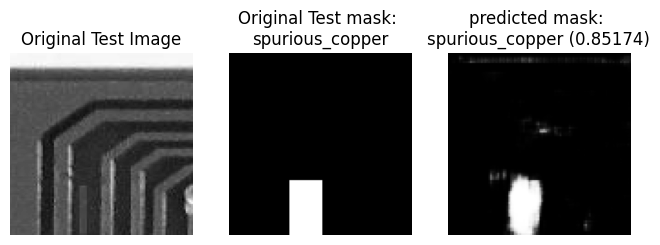

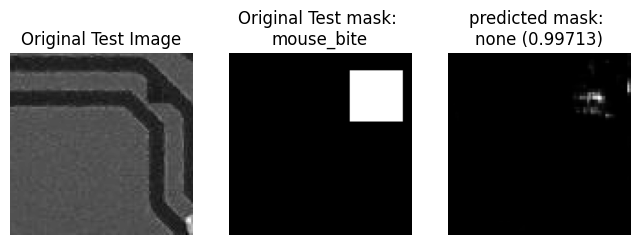

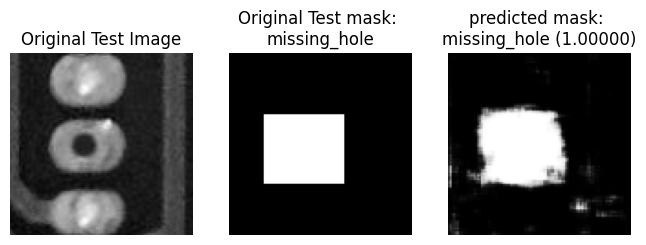

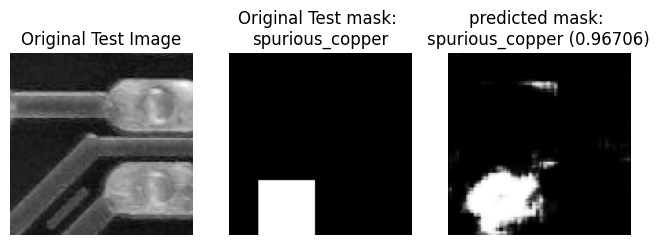

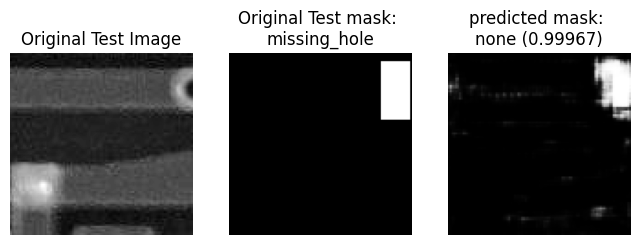

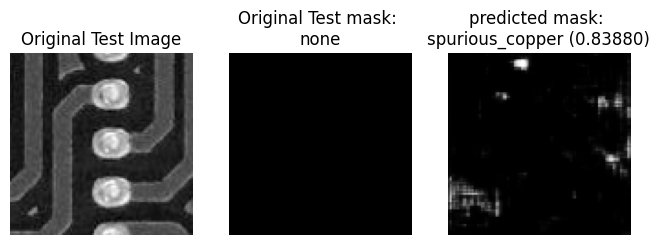

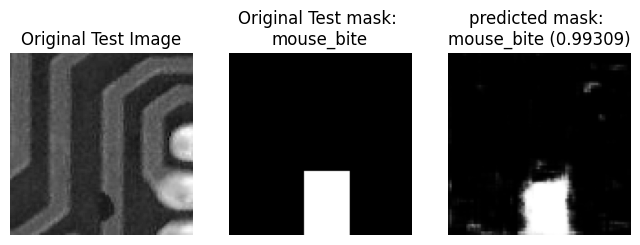

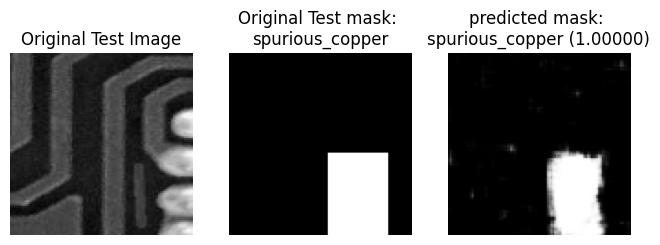

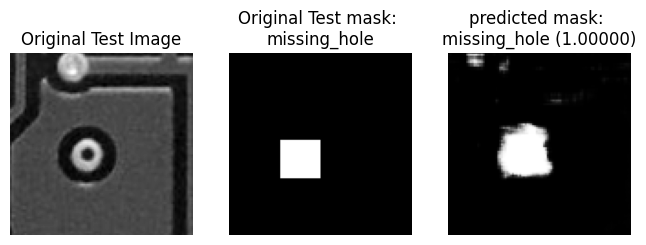

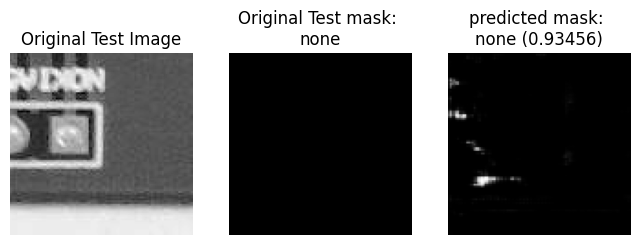

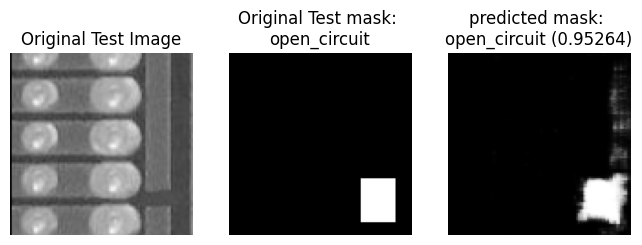

In [948]:

for i in range(0,30,1):
    output_probabilities = np.array(y_class_pred[i])
    confidence = np.max(output_probabilities)

      
    plt.figure(figsize = (8, 5))
    plt.subplot(131) 
    plt.imshow(X_test[i].squeeze(), cmap='gray')  
    plt.title('Original Test Image')
    plt.axis('off')

    plt.subplot(132)  
    plt.imshow(y_test_mask[i].squeeze(), cmap='gray') 
    plt.title('Original Test mask: \n' + remapped_test_labels[i])
    plt.axis('off')

    plt.subplot(133)  
    plt.imshow(y_mask_pred[i].squeeze(), cmap='gray')  
    plt.title(f'predicted mask: \n{remapped_labels[i]} ({confidence:.5f})')
    plt.axis('off')

    plt.show()
    



In [949]:
# Create a DataFrame for the true and predicted labels
df = pd.DataFrame({'True_Labels': remapped_test_labels, 'Predicted_Labels': remapped_labels})

# Create a crosstab
crosstab = pd.crosstab(df['Predicted_Labels'], df['True_Labels'])

print(crosstab)

True_Labels       missing_hole  mouse_bite  none  open_circuit  short  spur  \
Predicted_Labels                                                              
missing_hole                54           0     2             0      0     2   
mouse_bite                   2          42     2             3      0     2   
none                         1           4    49             2      3    17   
open_circuit                 0           4     4            40      1     1   
short                        0           0     2             0     47     4   
spur                         0           0     6             1      0    27   
spurious_copper              0           0     1             1      1     3   

True_Labels       spurious_copper  
Predicted_Labels                   
missing_hole                    1  
mouse_bite                      0  
none                            6  
open_circuit                    1  
short                           2  
spur                            6  


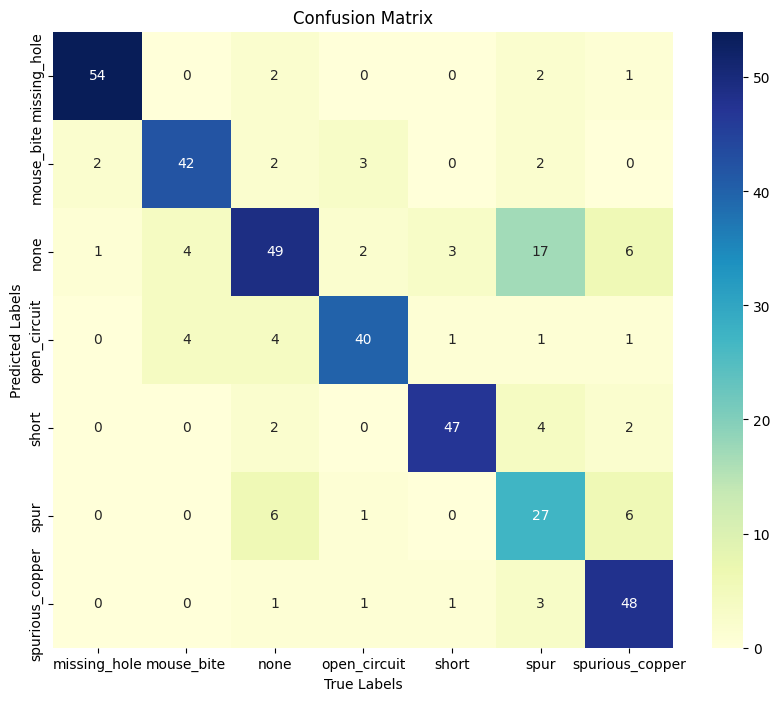

In [950]:
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(crosstab, annot=True, fmt="d", cmap="YlGnBu")
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.title('Confusion Matrix')
plt.show()

In [951]:
missing_hole_indices = np.where(predicted_labels == 5)[0]  # Get the indices directly
# Get the corresponding predicted masks for missing_hole predictions
missing_hole_masks = y_mask_pred[missing_hole_indices]
missing_hole_labels = np.array(remapped_labels)[missing_hole_indices]
print(len(missing_hole_indices))
print(missing_hole_indices)

'''
# Print the predicted masks  
for i in range(len(missing_hole_indices)):
    plt.imshow(missing_hole_masks[i].squeeze(), cmap='gray') 
    plt.title('Original Test mask: \n' + missing_hole_labels[i])
    plt.axis('off')
    
    plt.show()
    '''

40
[ 14  48  56  68  76  86  90 111 118 132 140 154 157 161 163 168 186 193
 195 196 204 207 211 233 245 250 262 265 268 269 276 281 290 318 332 347
 357 375 376 379]


"\n# Print the predicted masks  \nfor i in range(len(missing_hole_indices)):\n    plt.imshow(missing_hole_masks[i].squeeze(), cmap='gray') \n    plt.title('Original Test mask: \n' + missing_hole_labels[i])\n    plt.axis('off')\n    \n    plt.show()\n    "

In [952]:
image_test2 = []
gray_image2 = []
#image_test2 = cv2.imread('C:/users/wfaiz/Data_Science/PCB_Defect/data_full/Images/l_light_11_spur_02_5_600.jpg')
image_test2 = cv2.imread('C:/users/wfaiz/Data_Science/PCB_Defect/data_full/Images/l_light_01_missing_hole_17_3_600.jpg')

image_test2 = cv2.resize(image_test2, (600, 600)) 
gray_image2 = cv2.cvtColor(image_test2, cv2.COLOR_BGR2GRAY)
image_array_test2 = np.asarray(gray_image2) / 255.0 

In [953]:
image_array_test2 = np.expand_dims(image_array_test2, axis=0)  # Add batch dimension
y_pred2, y_class2 = model.predict(image_array_test2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 199s 199s/step


In [954]:
print(y_class2)
predicted_label2 = np.argmax(y_class2, axis=1)
remapped_label2 = [class_labels_pred[label] for label in predicted_label2]

# Print the remapped labels
print("Remapped Labels:", remapped_label2)

[[1.4264397e-06 9.6042197e-05 9.9790597e-01 1.1620053e-06 1.1807247e-07
  1.9952019e-03 1.0422879e-07]]
Remapped Labels: ['none']


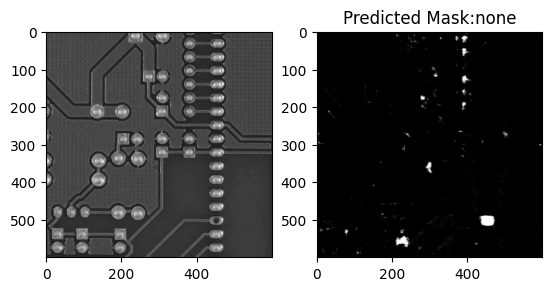

In [955]:

plt.subplot(121) 
plt.imshow(gray_image2.squeeze(), cmap='gray')

plt.subplot(122) 
plt.imshow(y_pred2.squeeze(), cmap='gray')
plt.title('Predicted Mask:' +remapped_label2[0])
plt.show()

In [956]:
image_test3 = []
gray_image3 = []
image_test3 = cv2.imread('C:/users/wfaiz/Data_Science/PCB_Defect/data_full/Images/l_light_11_spur_02_5_600.jpg')

image_test3 = cv2.resize(image_test3, (600, 600))  # Resize
gray_image3 = cv2.cvtColor(image_test3, cv2.COLOR_BGR2GRAY)
image_array_test3 = np.asarray(gray_image3) / 255.0 #normalize


In [957]:
def crop_image(image, crop_size=(100, 100)):
    crops = []
    print(image.shape)
    height, width = image.shape
    crop_height, crop_width = crop_size

    for i in range(0, height, crop_height):
        for j in range(0, width, crop_width):
            crop = image[i:i + crop_height, j:j + crop_width]
            if crop.shape[0] == crop_height and crop.shape[1] == crop_width:
                crops.append(crop)
    return crops

# Crop the normalized grayscale image into 100x100 sections
crops = np.asarray(crop_image(image_array_test3, crop_size=(100, 100)))


(600, 600)


In [958]:
#print(X_test.shape)
print(crops.shape)

(36, 100, 100)


In [959]:
y_pred3, y_class3 = model.predict(crops)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step


In [960]:
print(y_class3)
predicted_label3 = np.argmax(y_class3, axis=1)
remapped_label3 = [class_labels_pred[label] for label in predicted_label3]

# Print the remapped labels
print("Remapped Labels:", remapped_label3)

[[3.04276750e-06 1.73447497e-05 9.99964237e-01 1.27385783e-05
  2.36581695e-06 3.07958771e-07 2.45229970e-08]
 [3.19538973e-02 2.94769436e-01 3.33559334e-01 1.71220407e-01
  1.92396492e-02 6.14549667e-02 8.78023058e-02]
 [7.79258786e-03 9.50404644e-01 4.45522973e-03 2.24055699e-03
  5.13308821e-03 2.80198772e-02 1.95406238e-03]
 [2.40783058e-02 6.60667121e-01 1.12528108e-01 1.23932585e-01
  4.93176142e-03 6.88337833e-02 5.02835540e-03]
 [7.73567498e-01 1.80184189e-02 4.60341237e-02 3.38551179e-02
  7.53872423e-03 1.47942826e-02 1.06191859e-01]
 [2.17874927e-08 3.29630637e-07 9.99995947e-01 1.18729452e-06
  1.38221409e-07 2.42810324e-06 4.97574710e-08]
 [1.71640739e-02 3.61396535e-03 9.45066929e-01 5.37610892e-03
  2.15526875e-02 4.49392246e-03 2.73225131e-03]
 [4.22005961e-03 3.16114575e-02 6.40235066e-01 7.73960375e-04
  3.19412947e-01 2.35844892e-03 1.38797122e-03]
 [1.57962739e-03 1.35679729e-03 9.82903540e-01 6.86675683e-03
  4.60945885e-04 5.13234409e-03 1.70008326e-03]
 [2.179280

In [961]:
from collections import Counter
label_counts = Counter(remapped_labels)

filtered_labels = [label for label in remapped_labels if label != 'none']

label_counts = Counter(filtered_labels)

# Find the label with the maximum count
label = label_counts.most_common(1)[0][0]

# Print the count of each label
print("Label Counts:", label_counts)

# Print the label with the highest count
print("Label with highest count:", label)

Label Counts: Counter({'missing_hole': 59, 'short': 55, 'spurious_copper': 54, 'mouse_bite': 51, 'open_circuit': 51, 'spur': 40})
Label with highest count: missing_hole


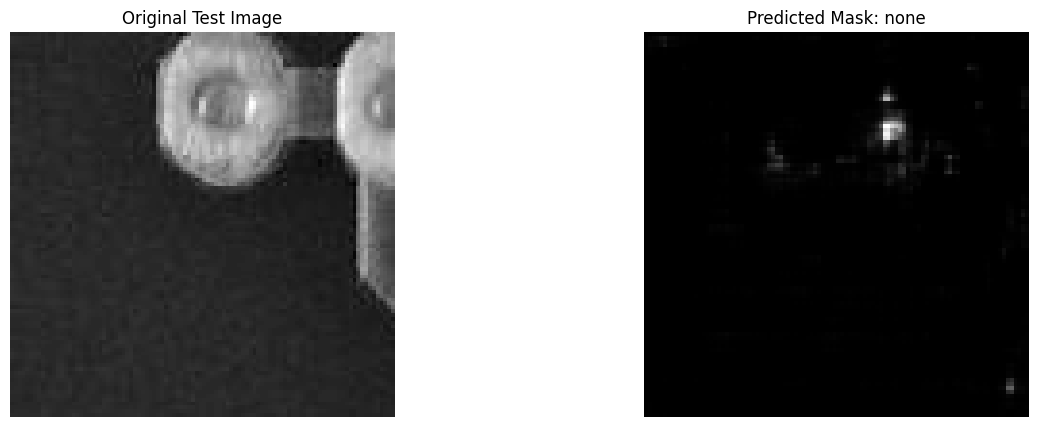

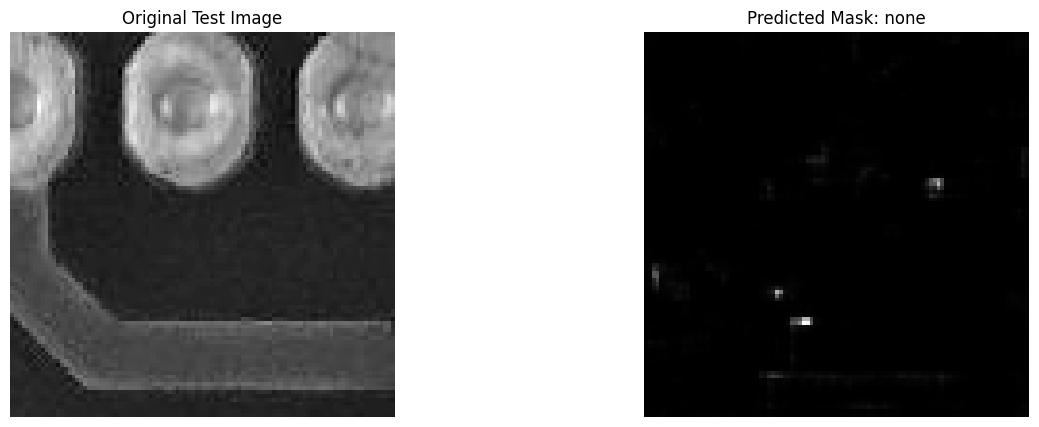

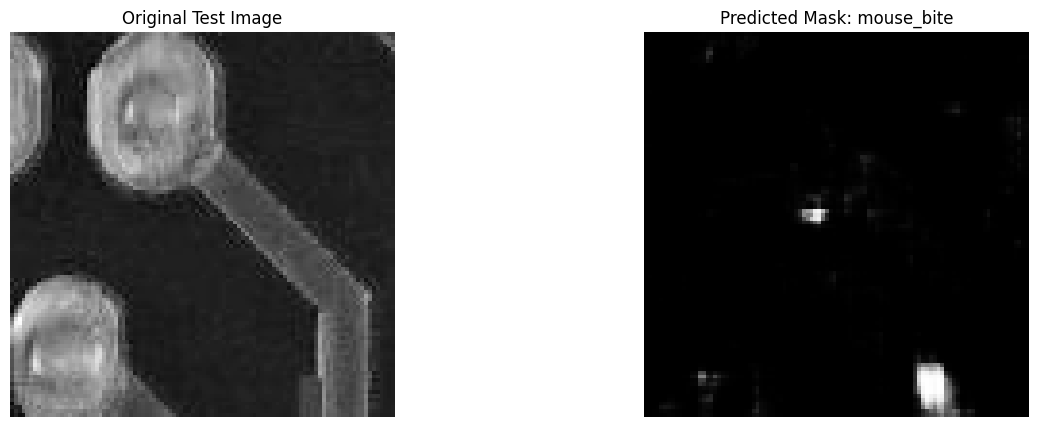

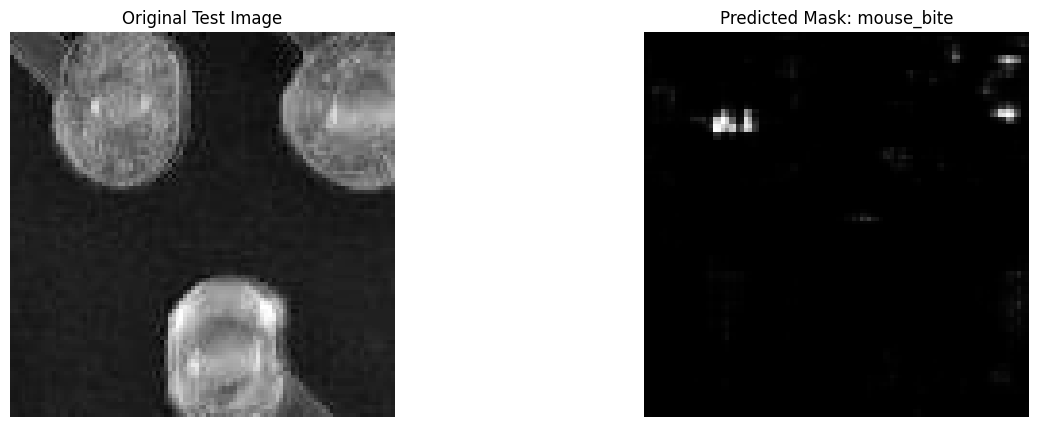

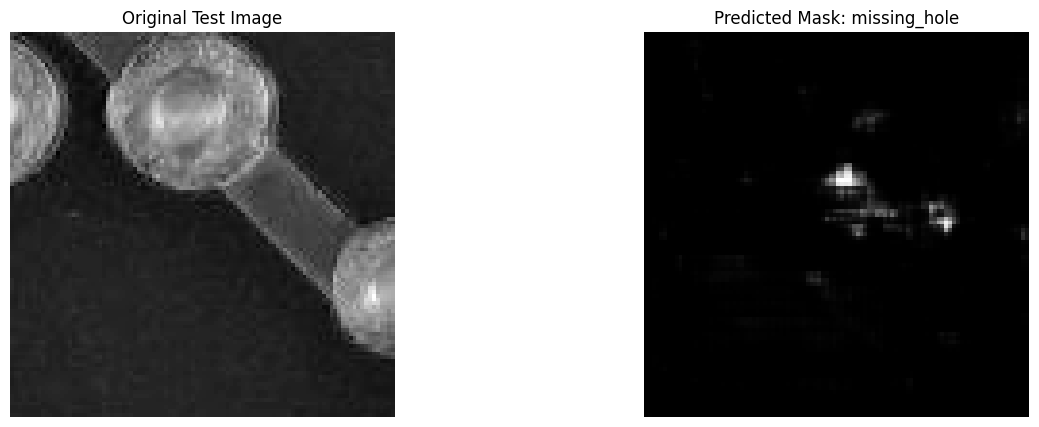

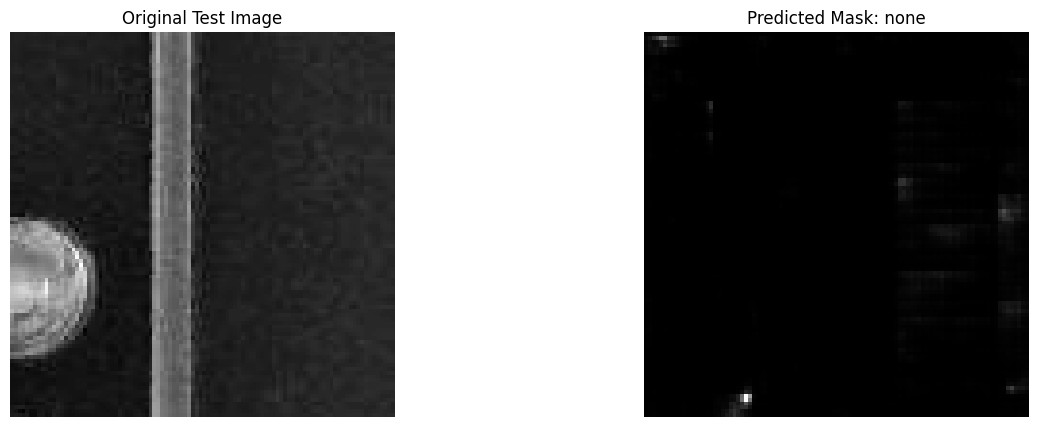

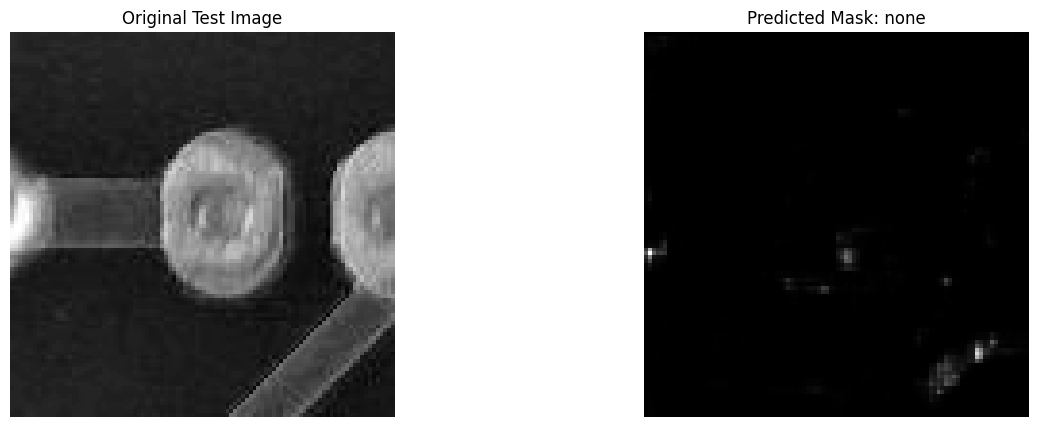

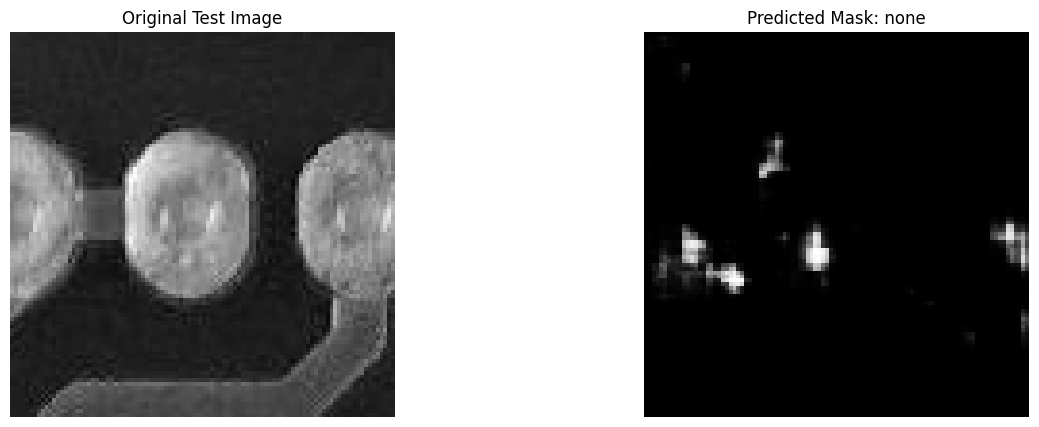

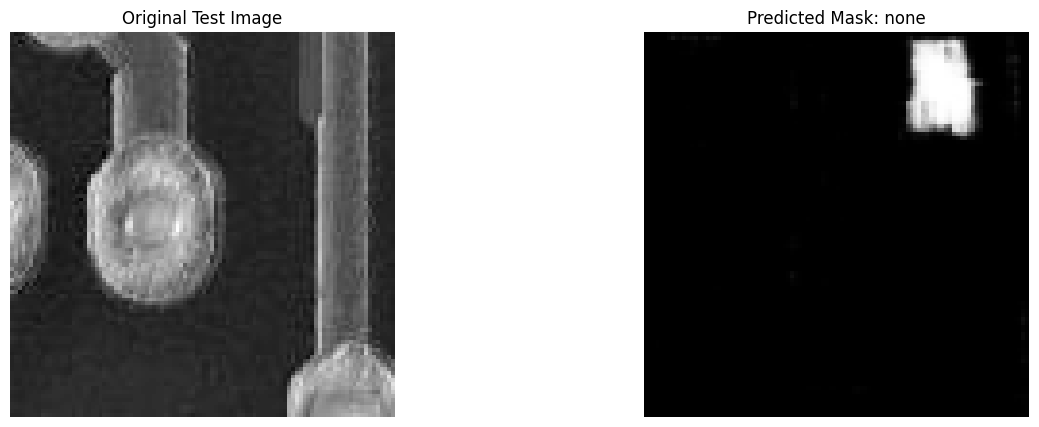

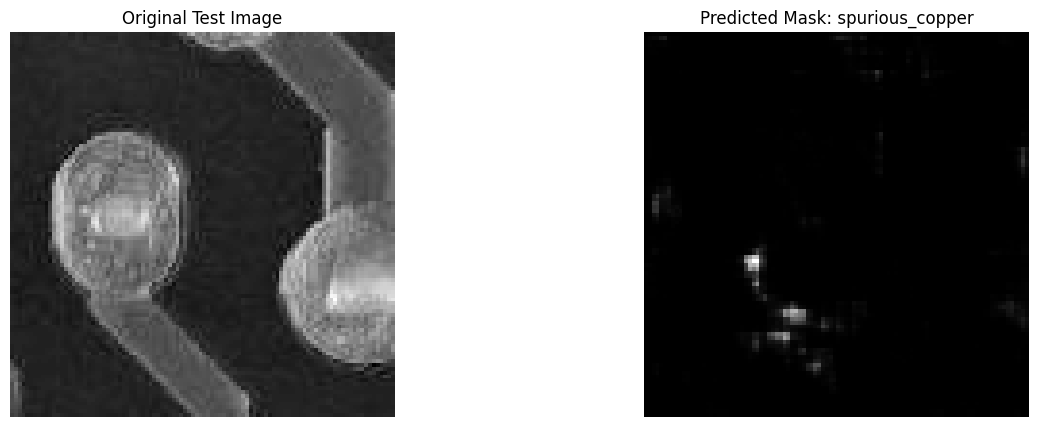

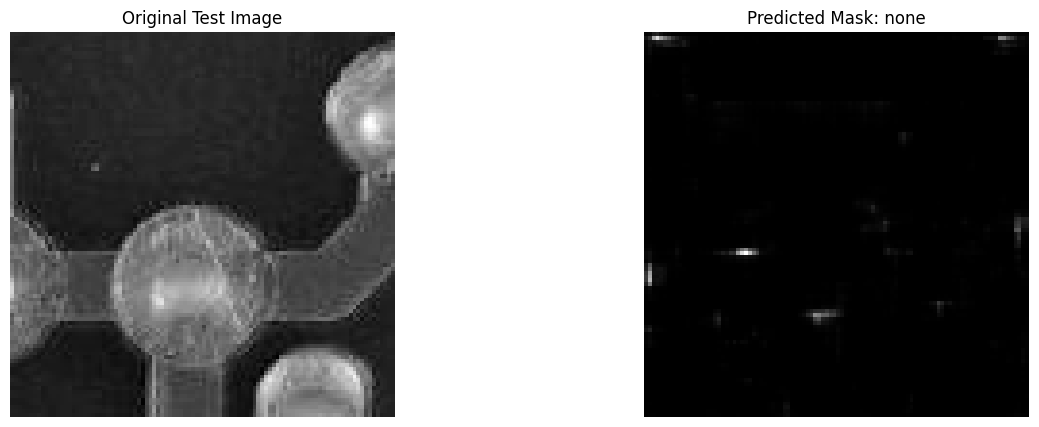

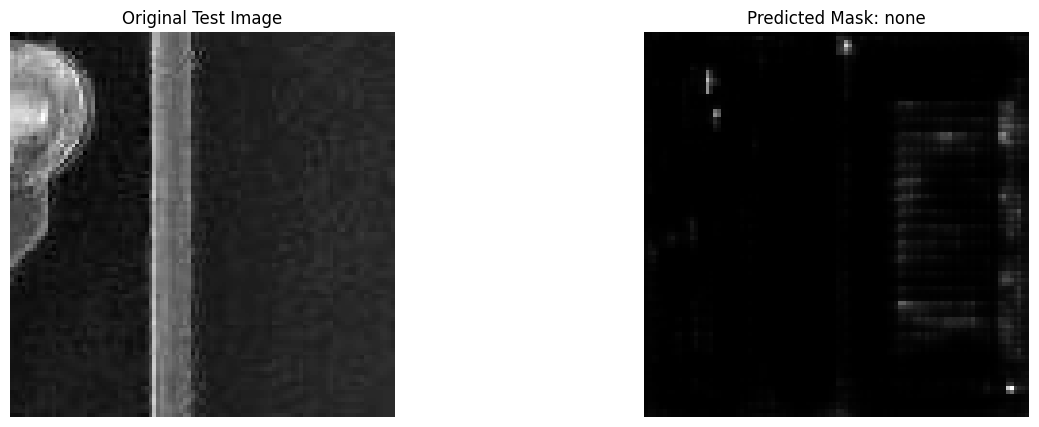

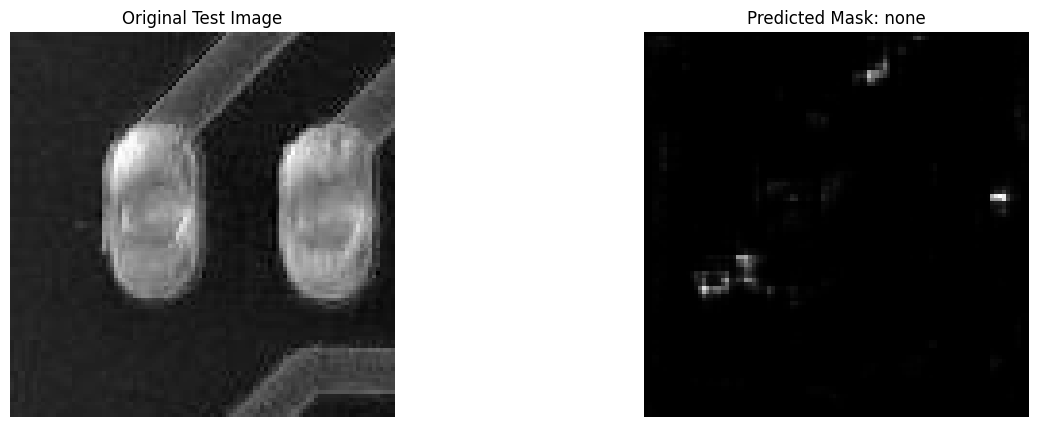

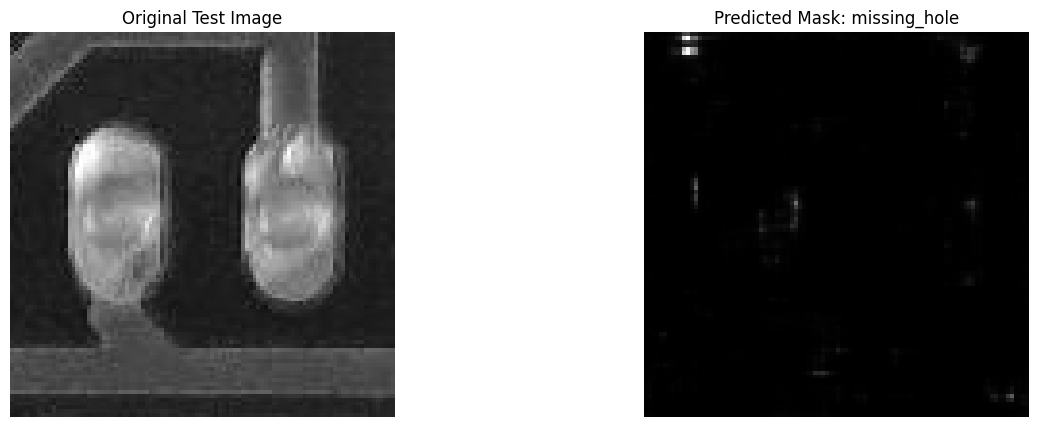

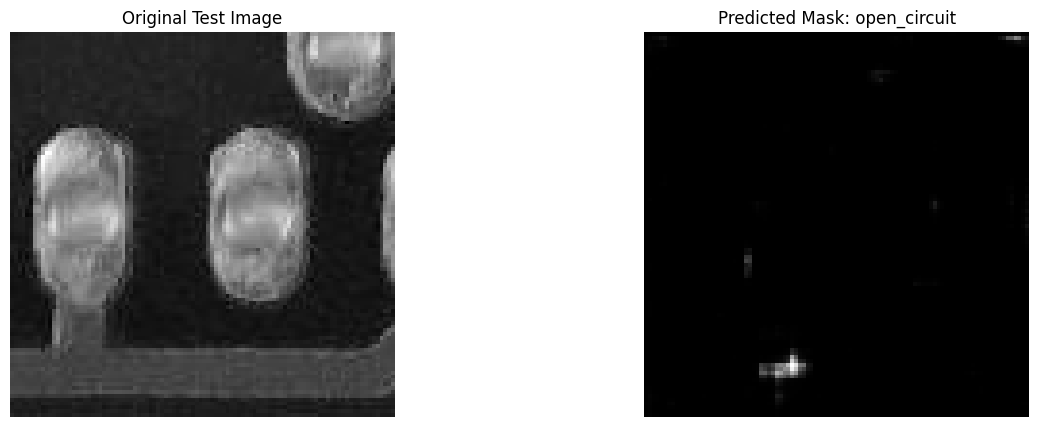

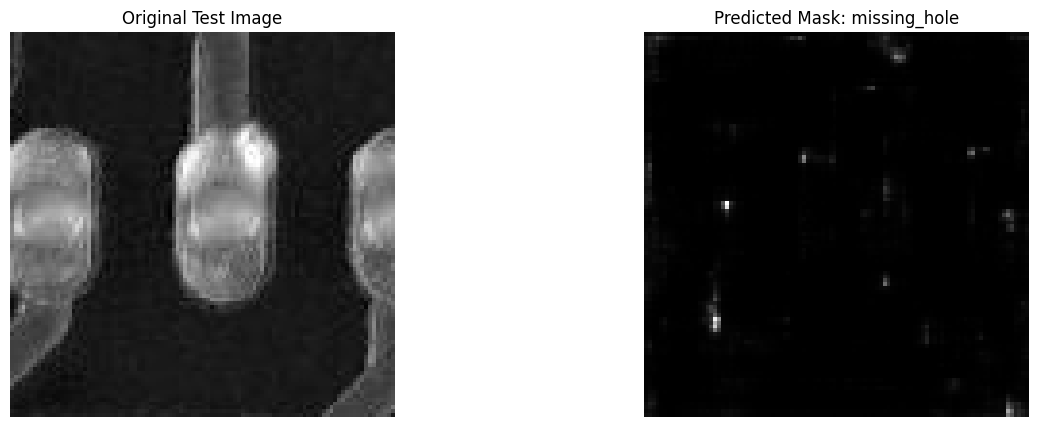

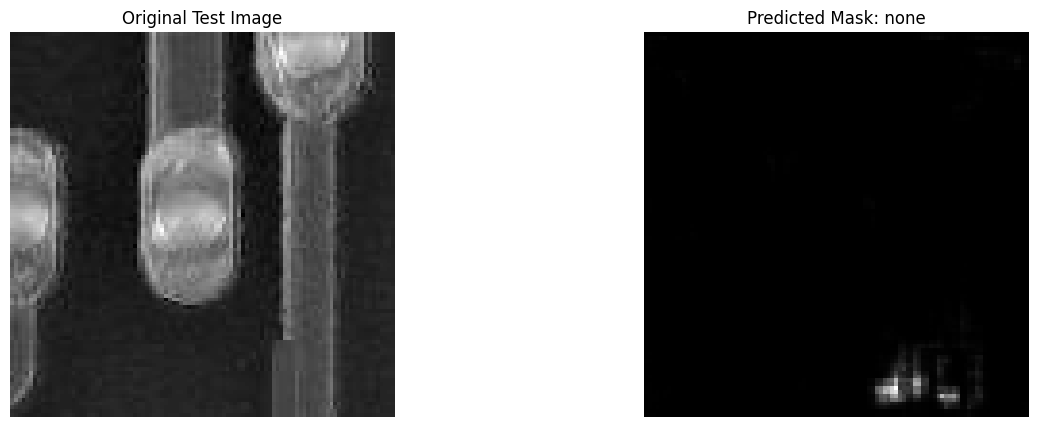

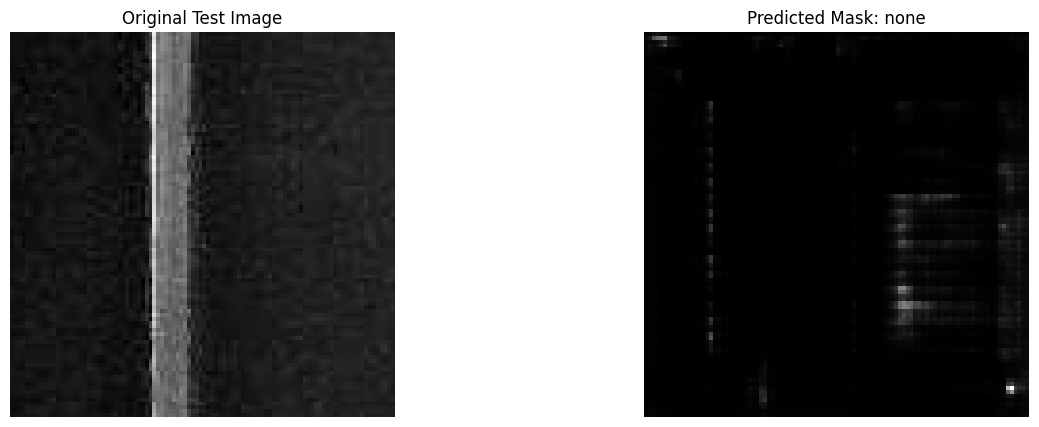

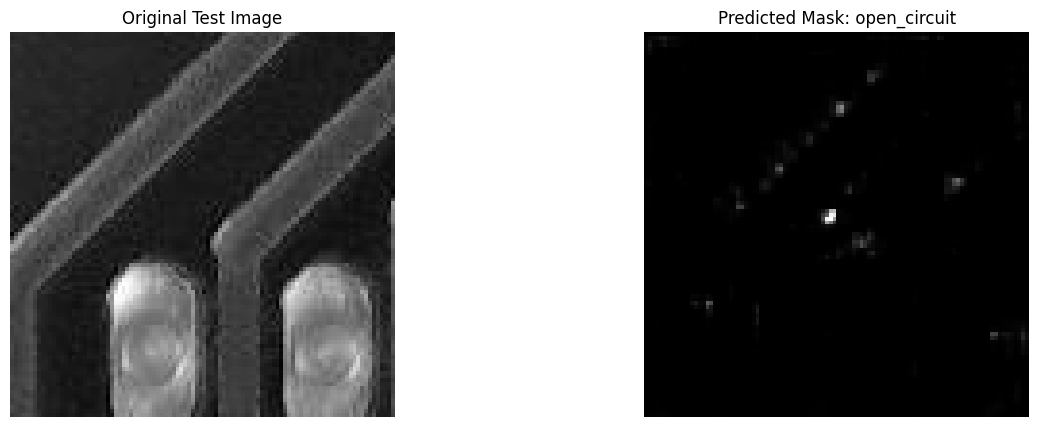

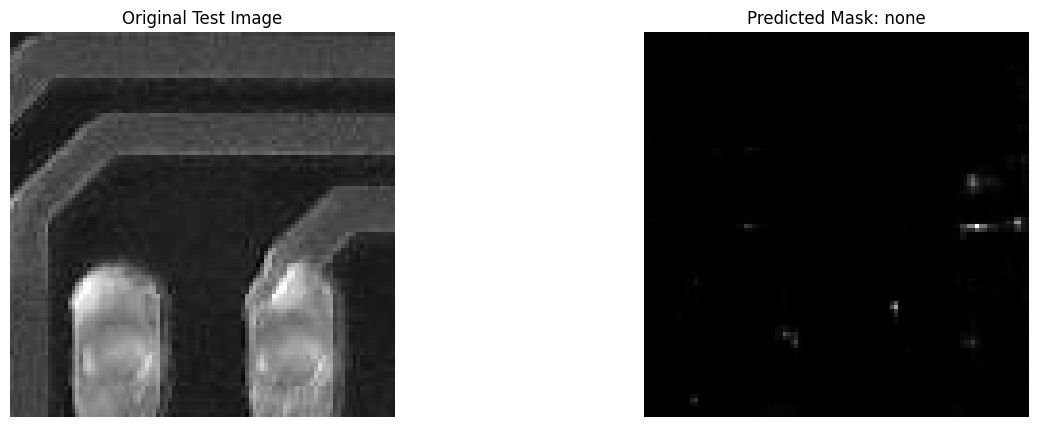

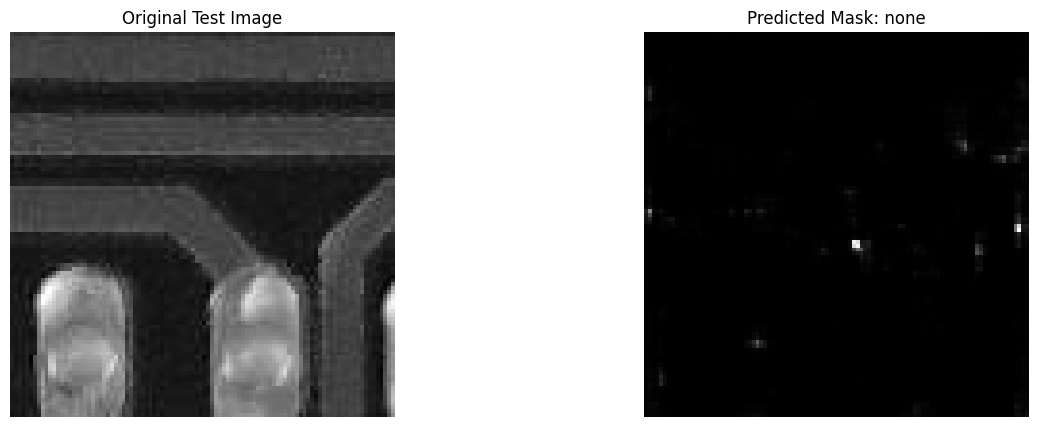

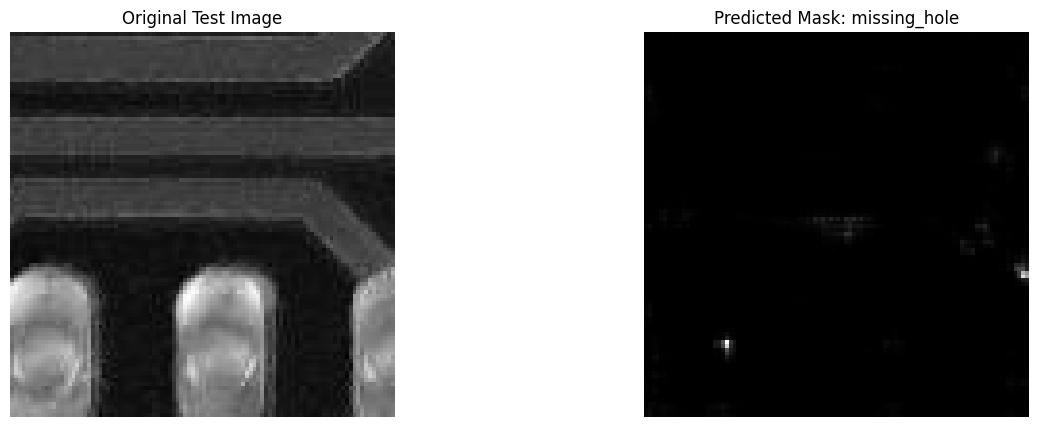

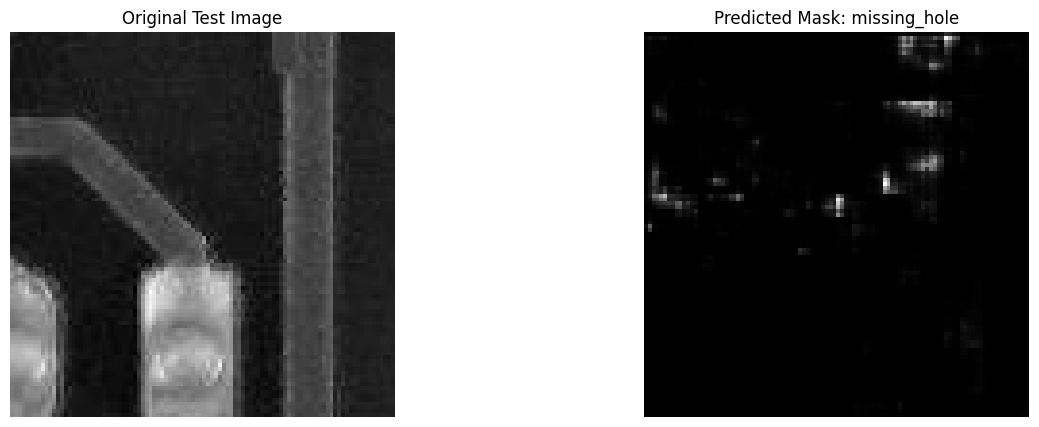

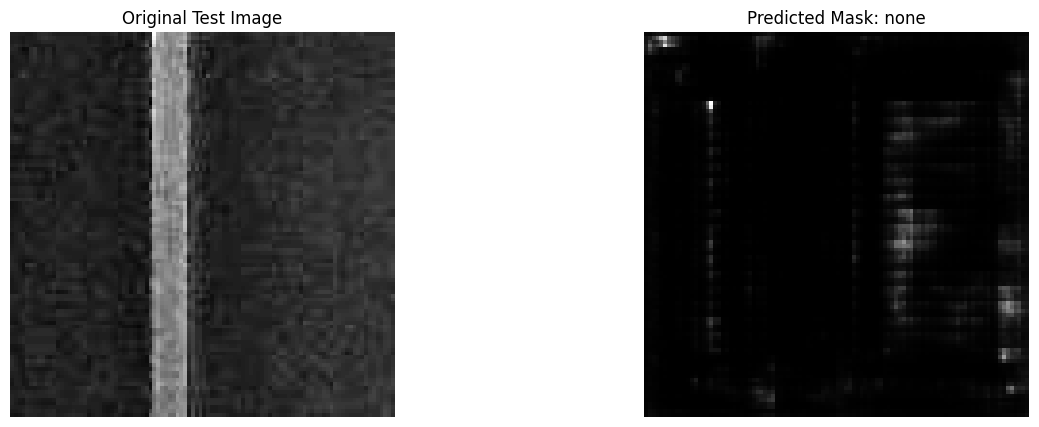

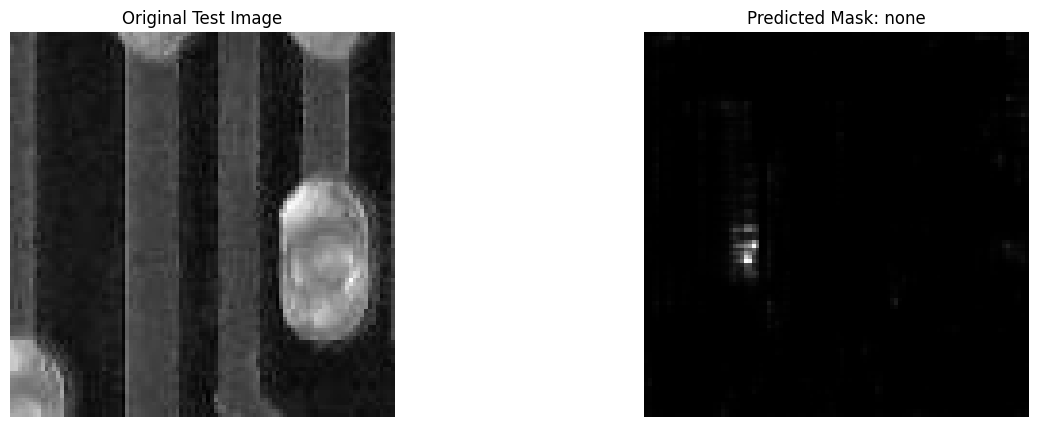

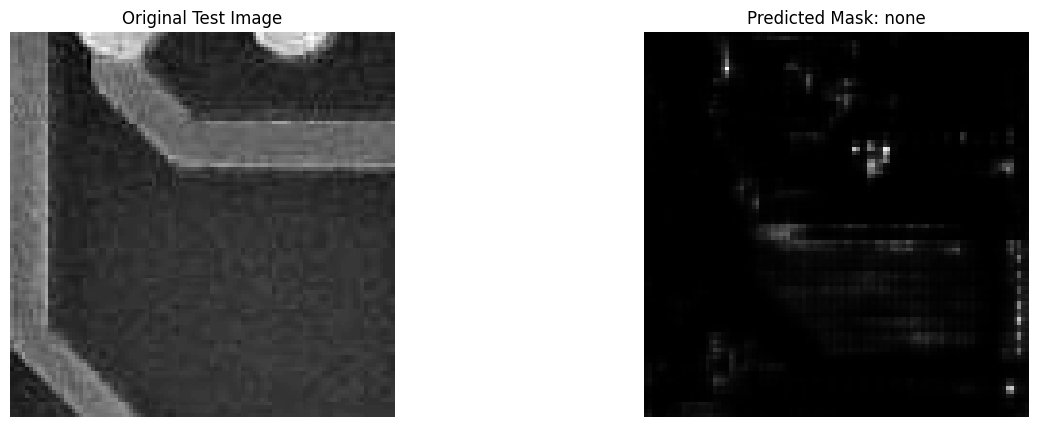

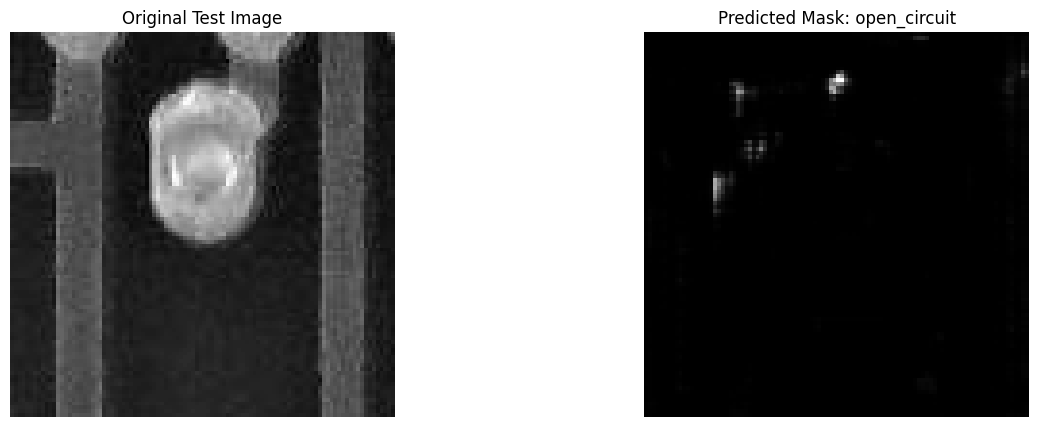

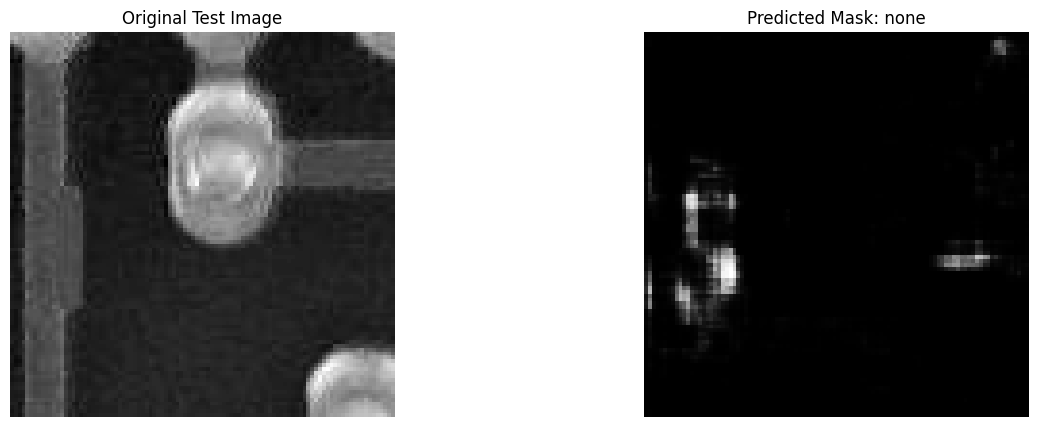

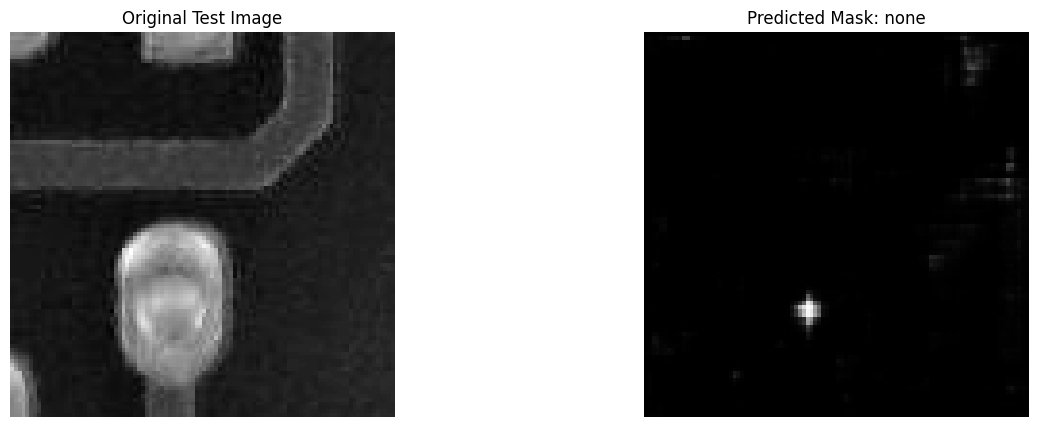

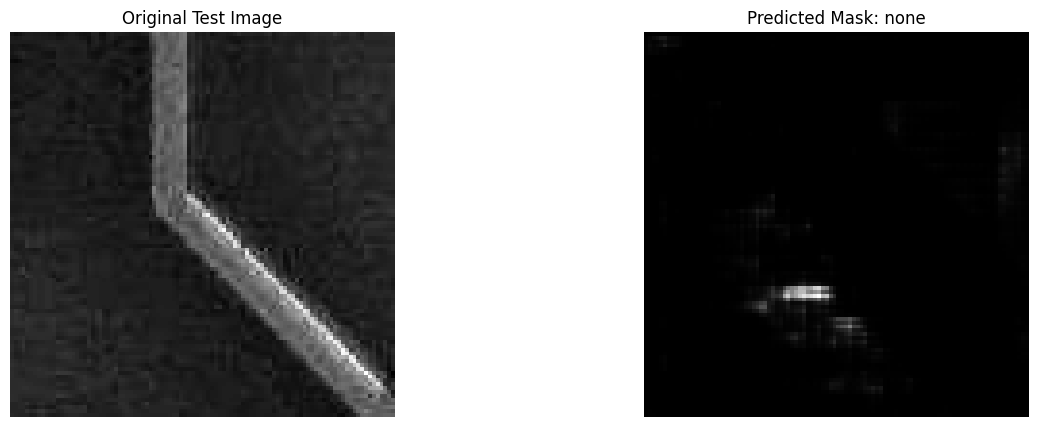

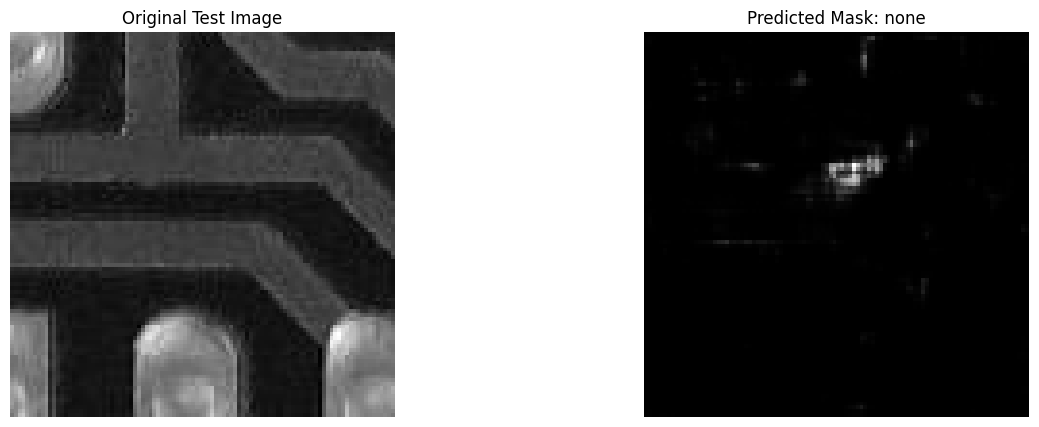

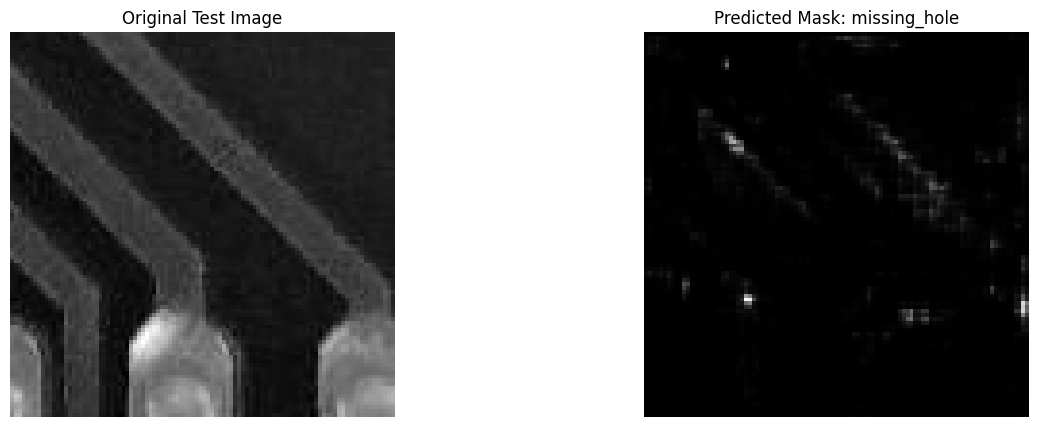

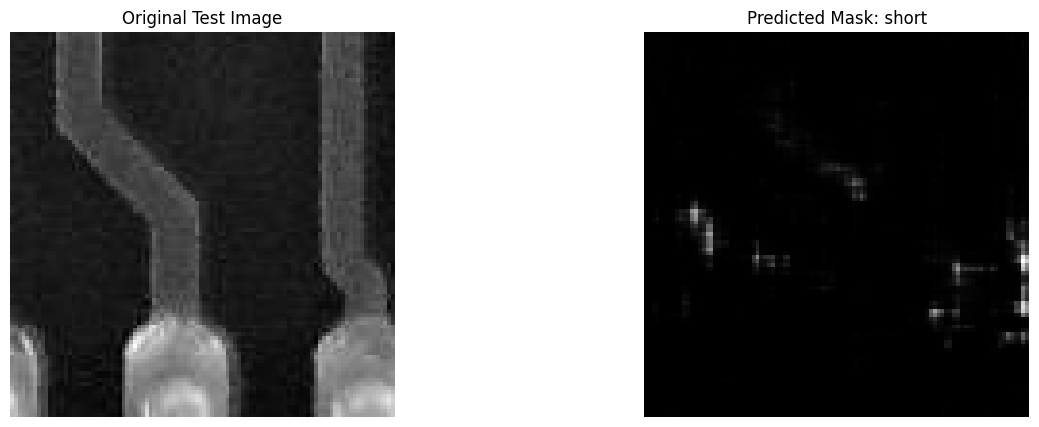

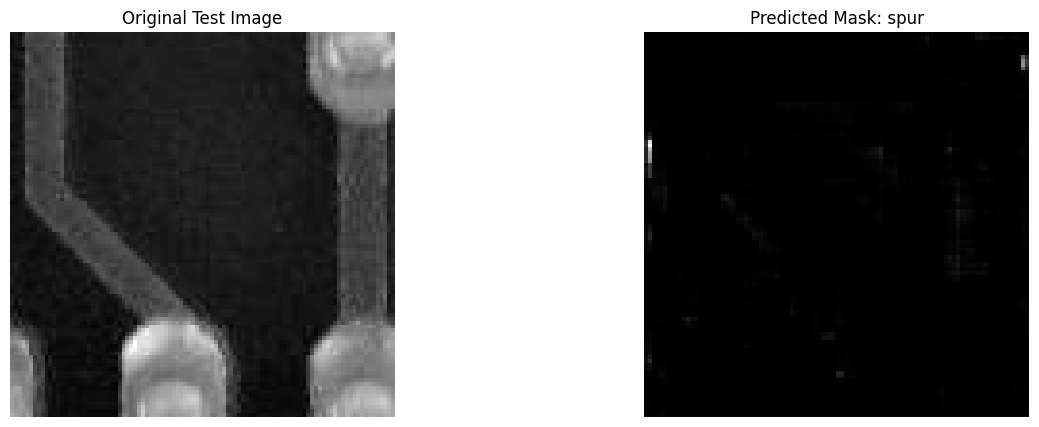

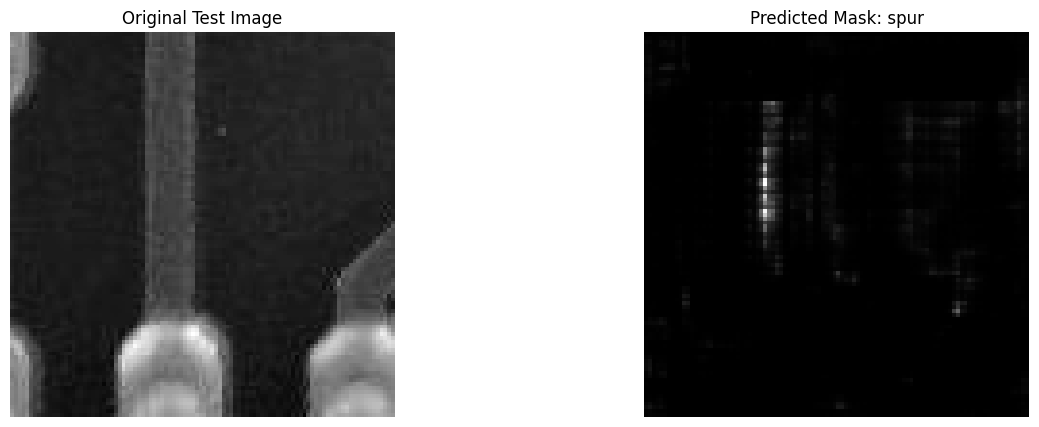

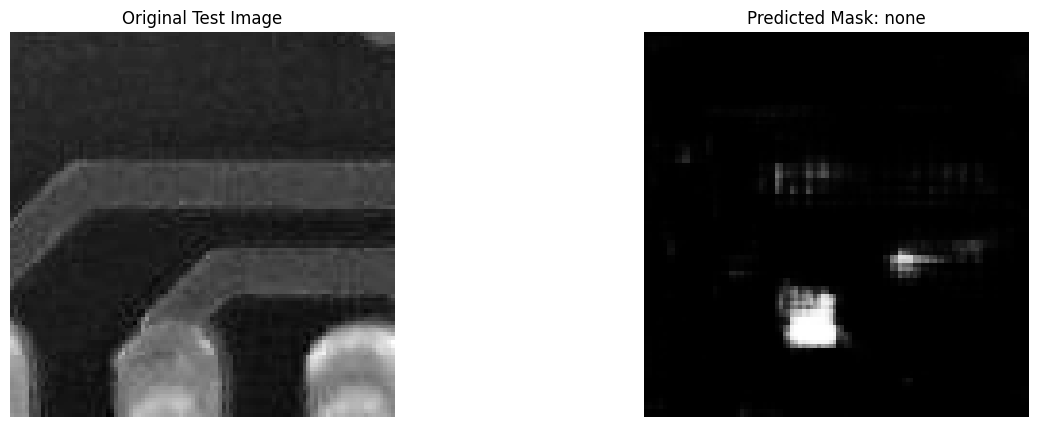

In [962]:
for i in range(36):

    plt.figure(figsize=(15, 5))

    plt.subplot(121)
    plt.imshow(crops[i], cmap='gray')
    plt.title('Original Test Image')
    plt.axis('off')


    plt.subplot(122)
    plt.imshow(y_pred3[i], cmap='gray')
    plt.title('Predicted Mask: ' +remapped_label3[i])
    plt.axis('off')

    plt.show()

In [963]:
def combine_crops(crops, crop_size=(100, 100), full_size=(600, 600)):
    rows = full_size[0] // crop_size[0]
    cols = full_size[1] // crop_size[1]
    combined_image = np.zeros(full_size)

    crop_idx = 0
    for i in range(rows):
        for j in range(cols):
            combined_image[i*crop_size[0]:(i+1)*crop_size[0], j*crop_size[1]:(j+1)*crop_size[1]] = crops[crop_idx]
            crop_idx += 1
    return combined_image

In [964]:
X_test_combined = combine_crops(crops)
#y_test_mask_combined = combine_crops(y_pred3.squeeze())
y_mask_pred_combined = combine_crops(y_pred3.squeeze())

In [965]:
crop_idx = 0
class_test = []
for i in range(0, 600, 100):
    for j in range(0, 600, 100):
        #if y_class3.squeeze()[crop_idx] != 'none':
        class_test.append(y_class3)
        crop_idx += 1

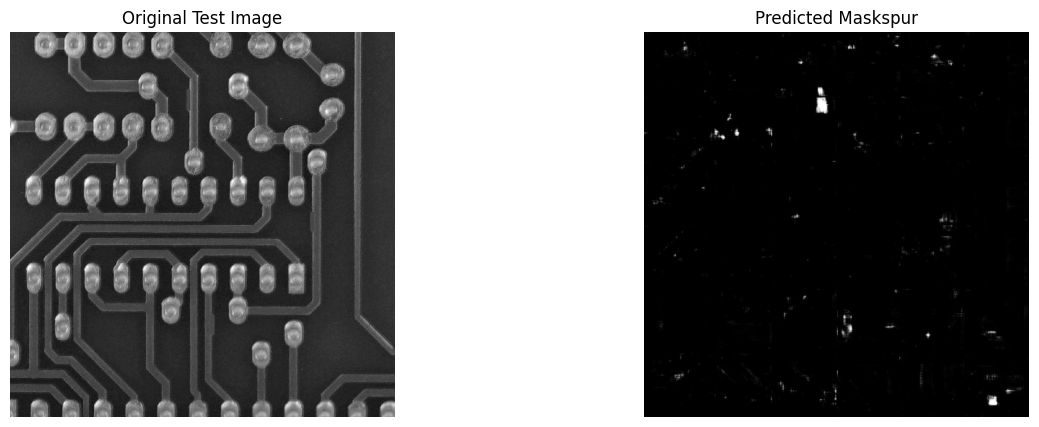

In [966]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.imshow(X_test_combined, cmap='gray')
plt.title('Original Test Image')
plt.axis('off')


plt.subplot(122)
plt.imshow(y_mask_pred_combined, cmap='gray')
plt.title('Predicted Mask' +remapped_label3[33])
plt.axis('off')

plt.show()

In [934]:
# Load the model from a file if needed for further training
from tensorflow.keras.models import load_model
model_path = 'model_enhanced_res_unet_2.keras'
'''
custom_objects = {
    #'focal_loss_fixed': focal_loss_fixed,
    #'DiceLoss': DiceLoss,
    'BinaryFocalCrossentropy': BinaryFocalCrossentropy,
    'CategoricalFocalCrossentropy': CategoricalFocalCrossentropy
}
'''
#model = load_model(model_path)#, custom_objects=custom_objects)

model = load_model(model_path, custom_objects={
    'MeanAbsoluteError': MeanAbsoluteError,
    'MeanIoU': MeanIoU,
    'Recall': Recall,
    'Precision': Precision
})